# Editor Retention



In [1]:
library(tidyverse)
library(broom)

# library(brms) # install.packages("brms")
# library(loo) # install.packages("loo")
# library(rstanarm) # install.packages("rstanarm")

library(lubridate)
library(bayesplot)

library(lme4)
library(yardstick) # install.packages("yardstick")

library(caret)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


This is bayesplot version 1.7.2

- Online documentation and vignettes at mc-stan.org/bayesplot

- bayesplot theme set to bayesplot::theme_default()

   * Does _not_ affect other ggplot2 plots

   * See ?bayesplot_theme_set for details on theme setting

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


For binary classification, the first factor level is assumed to be the event.
Use the 

# R Configuration variables

In [2]:
## NOTE: `loo`, which we use for model comparisons, has a tendency to use lots or run out of memory.
## Therefore, I've often had to set mc.cores to 1 before running it. However, if we set its `pointwise`
## parameter, it'll use less memory. And it'll use BLAS, so we restrict the number of BLAS threads to 1.
## Then mc.cores controls the number of parallel processes.

## blas_set_num_threads() also controls the number of threads that glmer() uses. Depending on the load
## on the server at the time we're doing our analysis we can tune the number of threads.

library(RhpcBLASctl)
blas_set_num_threads(1)
options(mc.cores = 4, digits = 3, scipen = 500)

# Give me wider plots, please
options(repr.plot.width = 14, repr.plot.height = 7)

# Helper functions

In [3]:
## Function that takes in a model, the validation set, the name of the predicted column,
## and returns a plot of the ROC curve
plot_ROC <- function(mod, val_data, col_name) {
    val_data$estimate = predict(mod, val_data, type = "response")
    roc_curve(val_data, {{ col_name }}, estimate, event_level = 'second') %>%
        ggplot(aes(x = 1 - specificity, y = sensitivity)) +
        geom_path() +
        geom_abline(lty = 3) +
        coord_equal() +
        theme_bw()
}

In [4]:
## Function that takes in the filename of the user edit data, reads it in,
## and creates all the various derived columns we need.
read_user_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = user_dataset_column_types) %>%
    mutate(
        Group = factor(hp_enabled, levels = c(0, 1), labels = c("C", "HP")),
        platform = factor(reg_on_mobile == 1, c(FALSE, TRUE), c("desktop", "mobile")),
        ## Registration month, for later joins on month
        reg_month = floor_date(user_registration_timestamp, unit = 'month'),
        # Number of edits:
        num_total_edits_24hrs = num_article_edits_24hrs + num_other_edits_24hrs,
        num_total_edits_2w = num_article_edits_2w + num_other_edits_2w,
        num_total_edits = num_total_edits_24hrs + num_total_edits_2w,
        num_total_article_edits = num_article_edits_24hrs + num_article_edits_2w,
        num_total_other_edits = num_other_edits_24hrs + num_total_edits_2w,
        # Log number of total edits is used as a control variable in the revert analysis
        log_num_total_edits = log(1 + num_total_edits),
        # Number of reverts:
        num_reverts_24hrs = num_article_reverts_24hrs + num_other_reverts_24hrs,
        num_reverts_2w = num_article_reverts_2w + num_other_reverts_2w,
        num_total_reverts = num_reverts_24hrs + num_reverts_2w,
        ## Control variables for the number of edits made (used for ex. in revert analysis)
        log_num_article_edits_24hrs = log(1 + num_article_edits_24hrs),
        log_num_other_edits_24hrs = log(1 + num_other_edits_24hrs),
        log_num_edits_24hrs = log(1 + num_article_edits_24hrs + num_other_edits_24hrs),
        # Control variables for the number of constructive edits made
        log_num_const_article_edits_24hrs = log(
            1 + num_article_edits_24hrs - num_article_reverts_24hrs),
        log_num_const_other_edits_24hrs = log(
            1 + num_other_edits_24hrs - num_other_reverts_24hrs),
        log_num_const_edits_24hrs = log(
            1 + num_article_edits_24hrs + num_other_edits_24hrs -
                num_article_reverts_24hrs - num_other_reverts_24hrs),
        # Revert rate:
        prop_rev_edits = ifelse(num_total_edits > 0, num_total_reverts / num_total_edits, 0),
        # Did they activate?
        is_activated_article = num_article_edits_24hrs > 0,
        is_activated_other = num_other_edits_24hrs > 0,
        is_activated = is_activated_article | is_activated_other,
        # Did they activate through constructive edits?
        is_const_activated_article = (num_article_edits_24hrs - num_article_reverts_24hrs) > 0,
        is_const_activated_other = (num_other_edits_24hrs - num_other_reverts_24hrs) > 0,
        is_const_activated = is_const_activated_article | is_const_activated_other,
        # Were they retained?
        is_retained_article = is_activated_article & (num_article_edits_2w > 0),
        is_retained_other = is_activated_other & (num_other_edits_2w > 0),
        is_retained = is_activated & ((num_article_edits_2w + num_other_edits_2w) > 0),
        # Were they retained through constructive edits?
        is_const_retained_article = is_const_activated_article &
            ((num_article_edits_2w - num_article_reverts_2w) > 0),
        is_const_retained_other = is_const_activated_other &
            ((num_other_edits_2w - num_other_reverts_2w) > 0),
        is_const_retained = is_const_activated &
            ((num_article_edits_2w + num_other_edits_2w -
              num_article_reverts_2w - num_other_reverts_2w) > 0)
    ) 
}

In [5]:
## Function that takes in the filename of the active editors dataset,
## and adds a registration month column for easy joining with the user dataset.
read_active_editors_dataset <- function(dataset_filename) {
    read_tsv(
        dataset_filename,
        col_types = active_editors_column_types) %>%
    mutate(wiki_db = factor(wiki_db),
           reg_month = month + months(1))
}

# Experiment Configuration Variables

We define a set of configuration variables that are useful for the analysis. One obvious one is where the edit dataset is located.

A less obvious one is a variable for when the experiment started. We often use this seeking to model the community's initial response to changes in newcomer behaviour, as well as long-term trends in the outcome variable when working with user data gathered across a relatively long time period.

In [6]:
## Path to the datasets with user edits
user_dataset_filenames <- c(
    '/home/nettrom/src/2021-Growth-structured-tasks/datasets/add-a-link-edit-data.tsv'
    )

## Column types in the dataset: wiki is a factor, HP variant is a factor, registration is a date time,
## everything else are integers.
user_dataset_column_types <- 'fiTiifiiiiiiii'

## Path to the dataset with counts of the number of active editors
active_editors_filenames <- c()

## Column types in the active editors dataset: month is a date, wiki is a factor
active_editors_column_types <- 'Dfiii'

## Deployment timestamps for Add a Link on each of the wikis
## Note that we turn wiki_db into a factor, otherwise wiki_db in the edit dataset
## becomes a character after joining the two.
exp_start_timestamps <- tribble(
    ~wiki_db, ~exp_start_timestamp,
    'arwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'bnwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'cswiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'viwiki', ymd_hms('2021-05-27 19:12:03', tz = 'UTC'),
    'fawiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'frwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'huwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'plwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'rowiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),
    'ruwiki', ymd_hms('2021-07-21 11:11:21', tz = 'UTC'),

) %>% mutate(wiki_db = factor(wiki_db))

## Path to the dataset with editing status at account registration
editing_status_filenames <- c()

## Column types in the editing status dataset: wiki is a factor, everything else are integers
editing_status_column_types <- 'fii'

## Path to the dataset with Welcome Survey responses
survey_response_filenames <- c()

## Columns types in the survey response data: user ID is an integer, number of languages is a number,
## everything else are factors
survey_response_column_types <- 'fifffn'

# Data import and setup

In [7]:
user_edit_data <- map_dfr(user_dataset_filenames, read_user_dataset)

In [8]:
nrow(user_edit_data)

[1] 130179

## Time since experiment start

Join the edits data with the experiment timestamps and measure time since the start to enable controlling for that:

In [9]:
user_edit_data <- user_edit_data %>%
    inner_join(exp_start_timestamps, by = 'wiki_db') %>%
    mutate(
        # Time as a measurement since deployment
        exp_days = difftime(user_registration_timestamp, exp_start_timestamp, units = 'days'),
        ln_exp_days = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days))),
        ln_exp_weeks = ifelse(exp_days < 0, 0, log(1 + as.numeric(exp_days)/7))
    )

In [10]:
nrow(user_edit_data)

[1] 130179

Made sure that we're not dropping any users at this stage, we're good to move forward.

## Additional variables

We've previously focused on Control vs Growth Features in our analysis. In this case we'll focus primarily on Unstructured Link Task vs Add a Link, but also check against the control group. This means we want the single variable `Group` to reflect one of three options depending on `hp_enabled` and `hp_variant`

In [11]:
user_edit_data <- user_edit_data %>%
    mutate(Group = factor(ifelse(
        hp_enabled == 0, 'Control',
        ifelse(hp_variant == 'control', 'Unstructured', 'Add-a-link')),
                          c('Control', 'Unstructured', 'Add-a-link')))

## Checking number of accounts for each wiki

We might be looking at very small wikis, in case we might want to not include them in the analysis.

In [12]:
user_edit_data %>%
    group_by(wiki_db, Group) %>%
    summarize(n = n())

`summarise()` regrouping output by 'wiki_db' (override with `.groups` argument)



wiki_db,Group,n
<fct>,<fct>,<int>
arwiki,Control,7698
arwiki,Unstructured,13426
arwiki,Add-a-link,13213
bnwiki,Control,1583
bnwiki,Unstructured,2664
bnwiki,Add-a-link,2679
cswiki,Control,787
cswiki,Unstructured,1419
cswiki,Add-a-link,1447


## Splitting into Training, Test, and Validation Datasets

Split the dataset into training, test, and validation data sets.

In [13]:
## set the random seed so train/test/validation splits can be reproduced
set.seed(42)

trainIndex <- caret::createDataPartition(user_edit_data$Group,
                                         p = .8,
                                         list = FALSE,
                                         times = 1)
user_data_train = user_edit_data[trainIndex,]
user_data_second = user_edit_data[-trainIndex,]

testIndex = caret::createDataPartition(user_data_second$Group, p = .5, list = FALSE, times = 1)

user_data_test = user_data_second[testIndex,]
user_data_validate = user_data_second[-testIndex,]

Warning message:
“The `i` argument of ``[`()` can't be a matrix as of tibble 3.0.0.
Convert to a vector.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”


In [14]:
user_data_test$is_activated_fct <- factor(user_data_test$is_activated,
                                          labels = c('No', 'Yes'))
user_data_validate$is_activated_fct <- factor(user_data_validate$is_activated,
                                          labels = c('No', 'Yes'))

## Visualizing Retention

We'll plot bar charts for retention for the Control, Unstructured, and Add-a-Link user groups.

### Retention

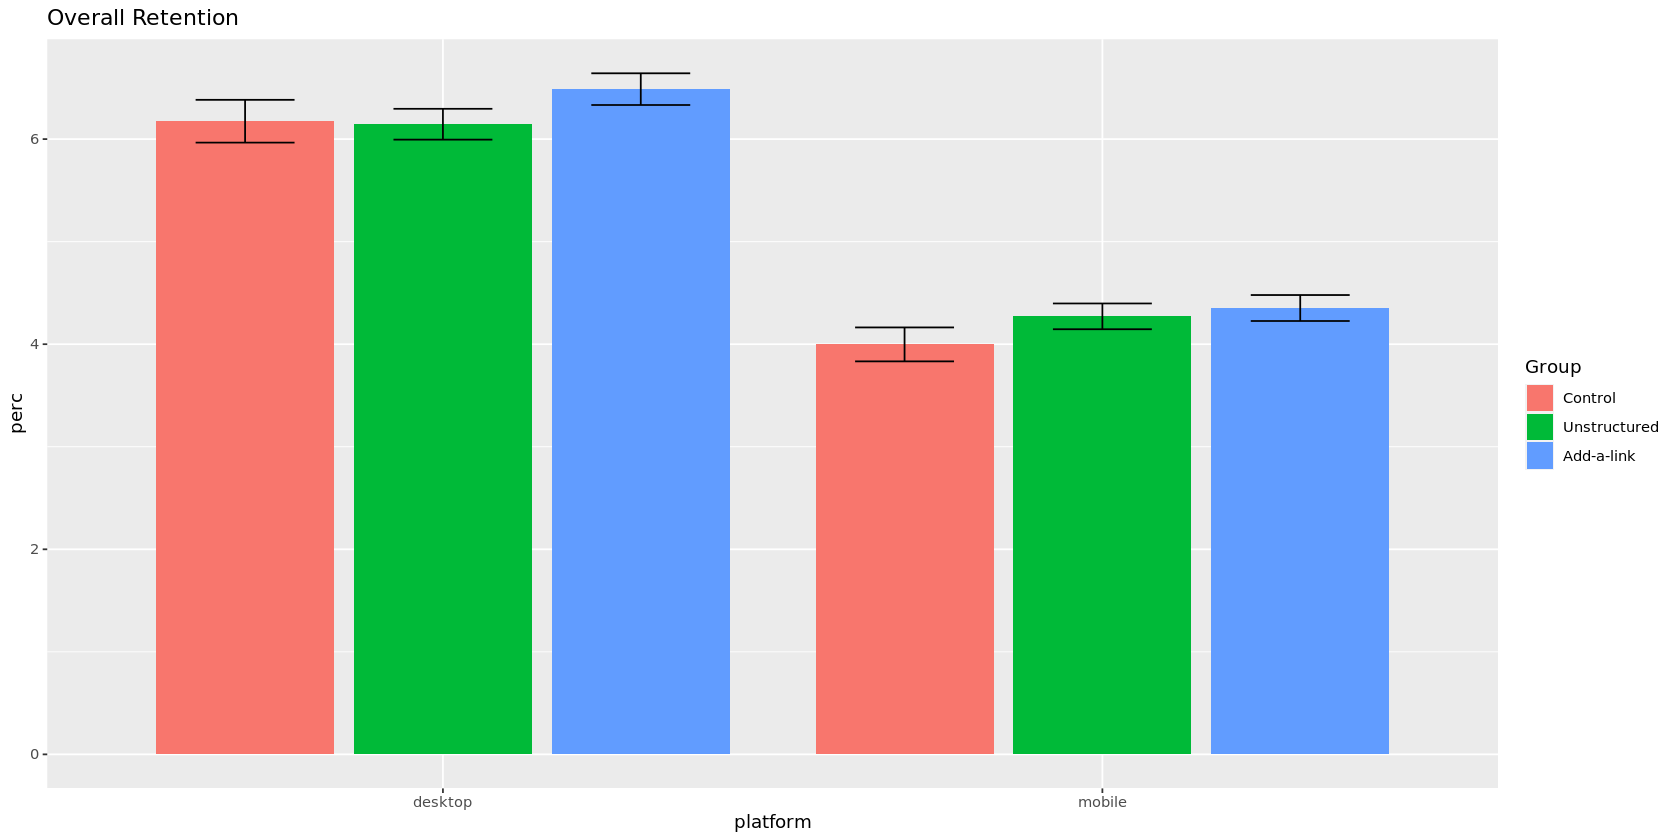

In [23]:
user_edit_data %>%
    group_by(platform, Group, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Overall Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

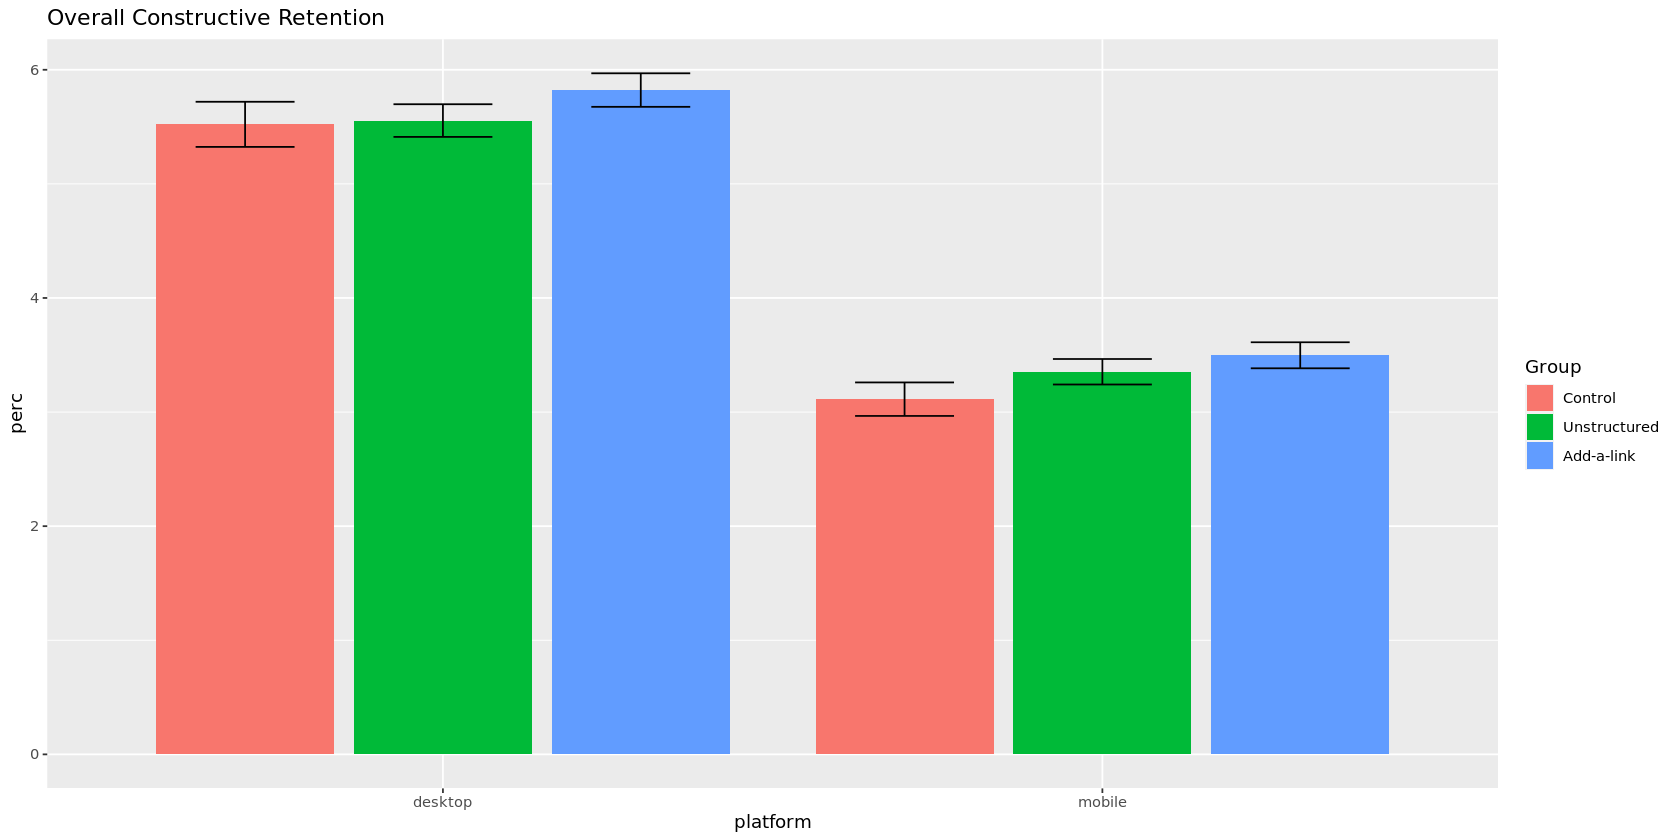

In [24]:
user_edit_data %>%
    group_by(platform, Group, is_const_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Overall Constructive Retention') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

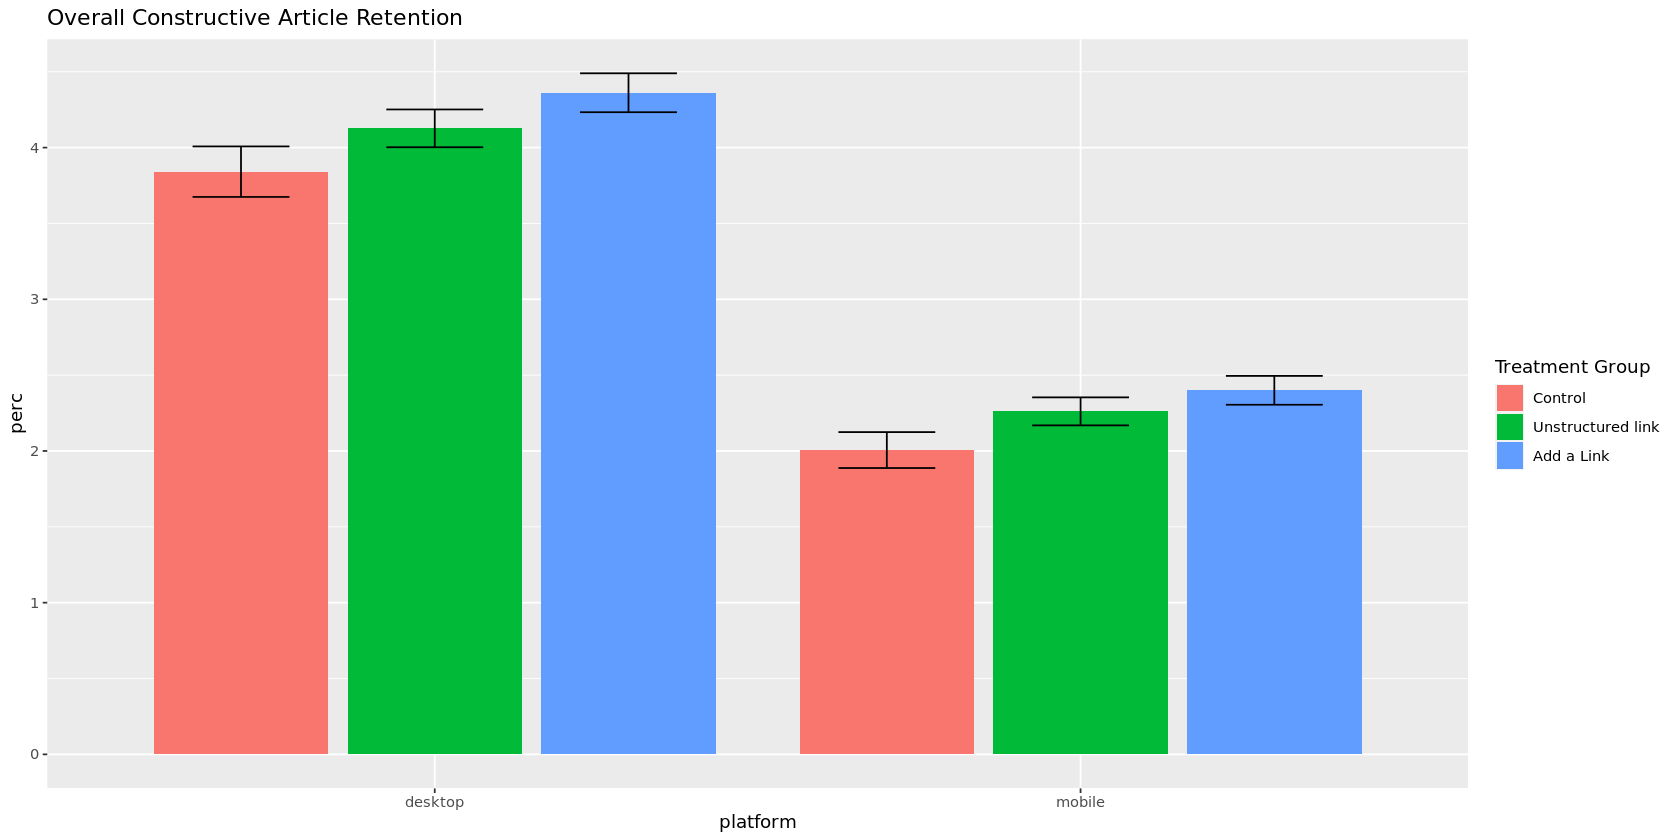

In [25]:
user_edit_data %>%
    group_by(platform, Group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Overall Constructive Article Retention') +
        scale_fill_discrete(name = "Treatment Group",
                            breaks = c("Control", "Unstructured", "Add-a-link"),
                            labels = c("Control", "Unstructured link", "Add a Link")) +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

### Retention Based on Activation

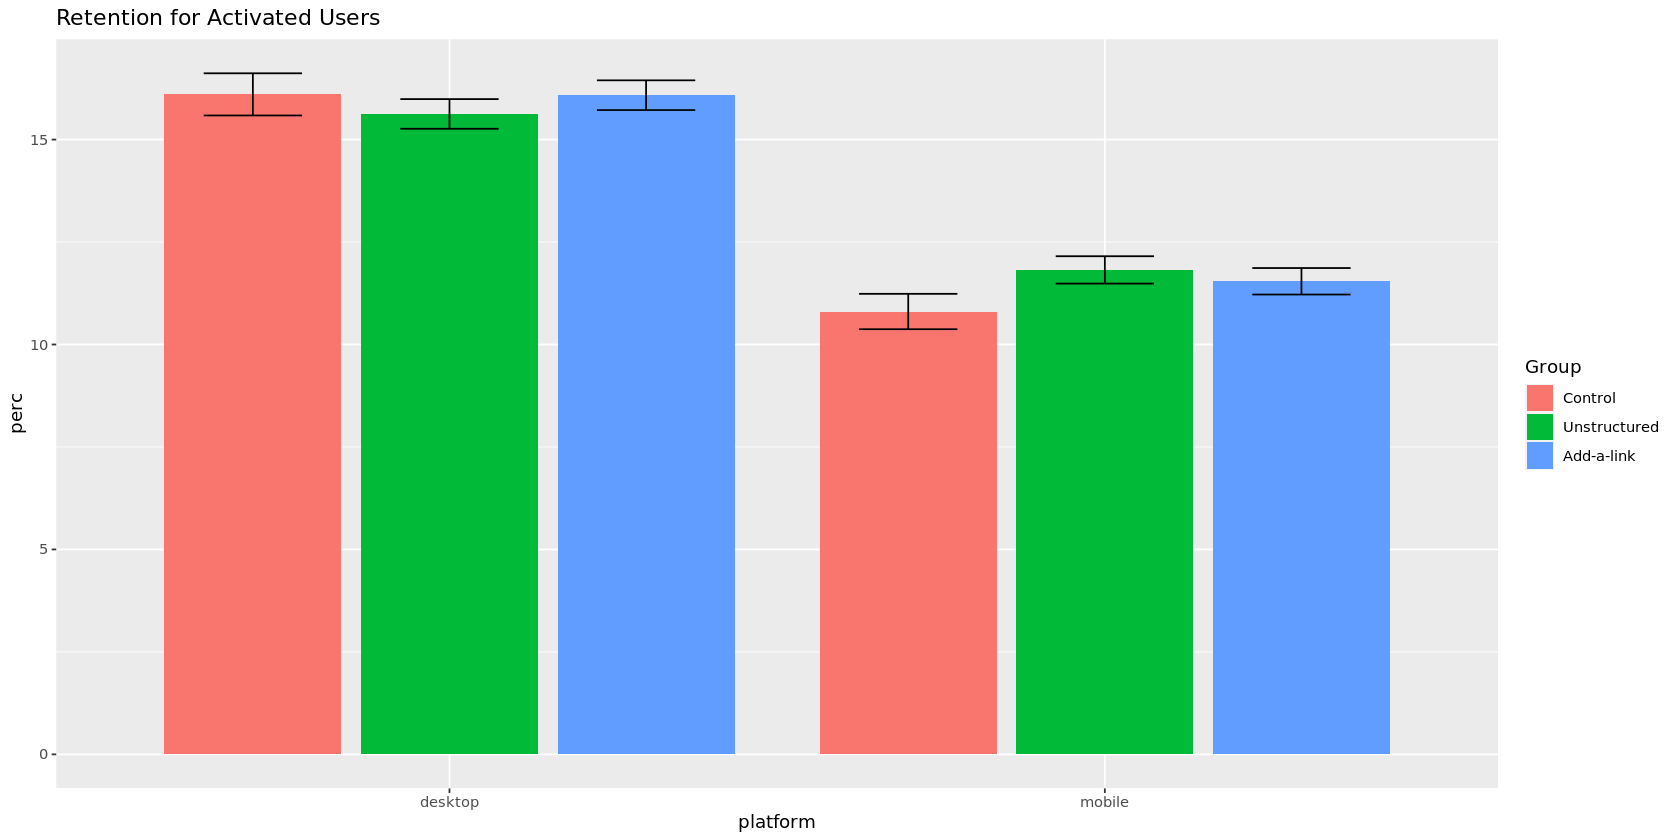

In [28]:
user_edit_data %>%
    filter(is_activated == TRUE) %>%
    group_by(platform, Group, is_retained) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Retention for Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

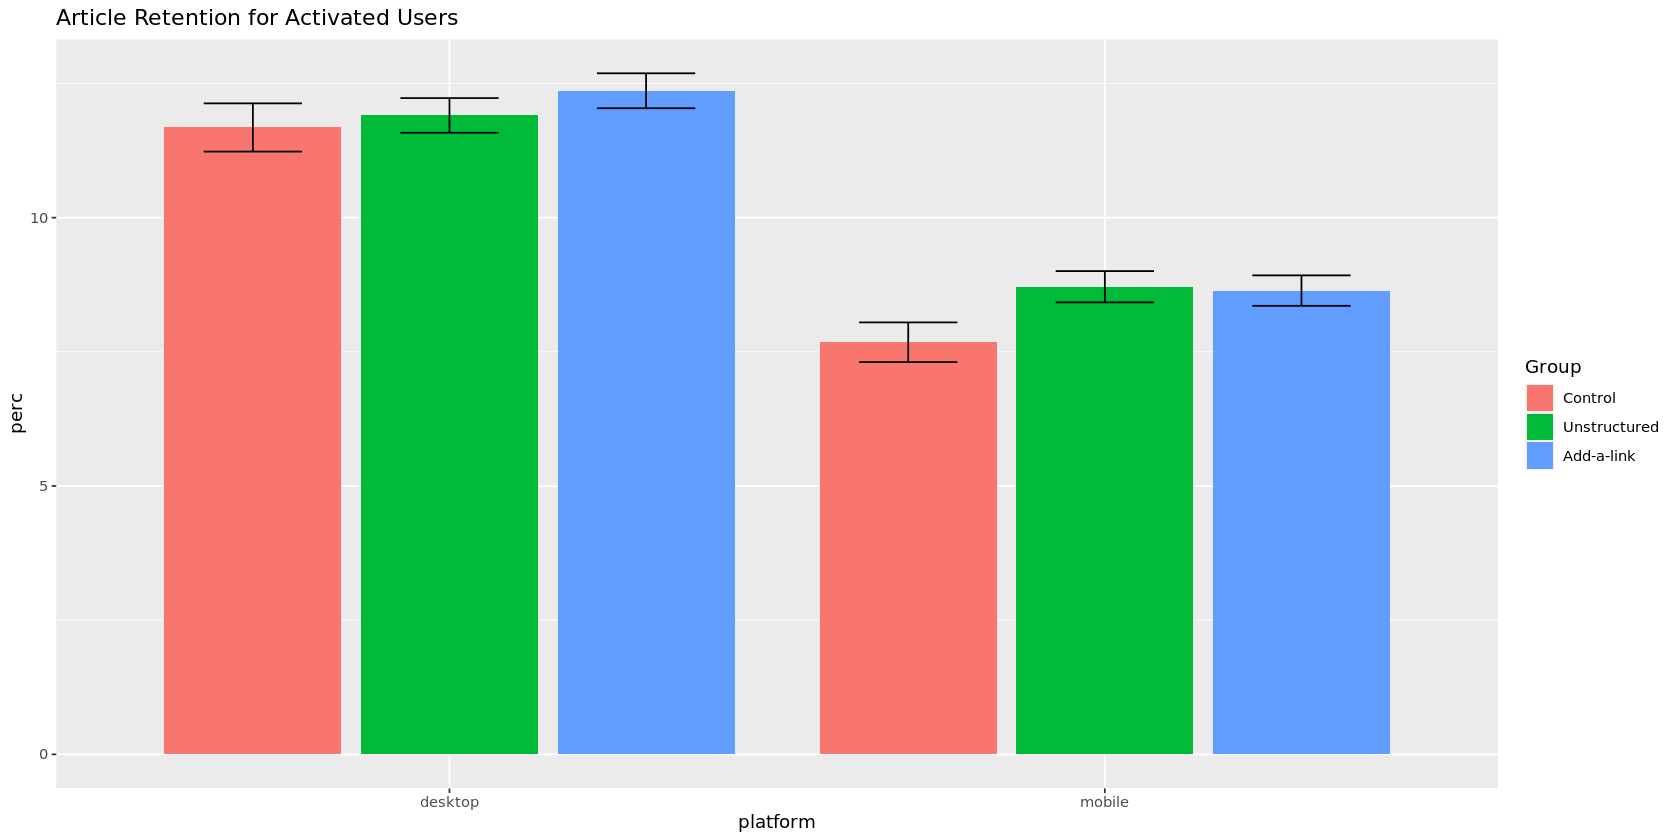

In [30]:
user_edit_data %>%
    filter(is_activated == TRUE) %>%
    group_by(platform, Group, is_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Article Retention for Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

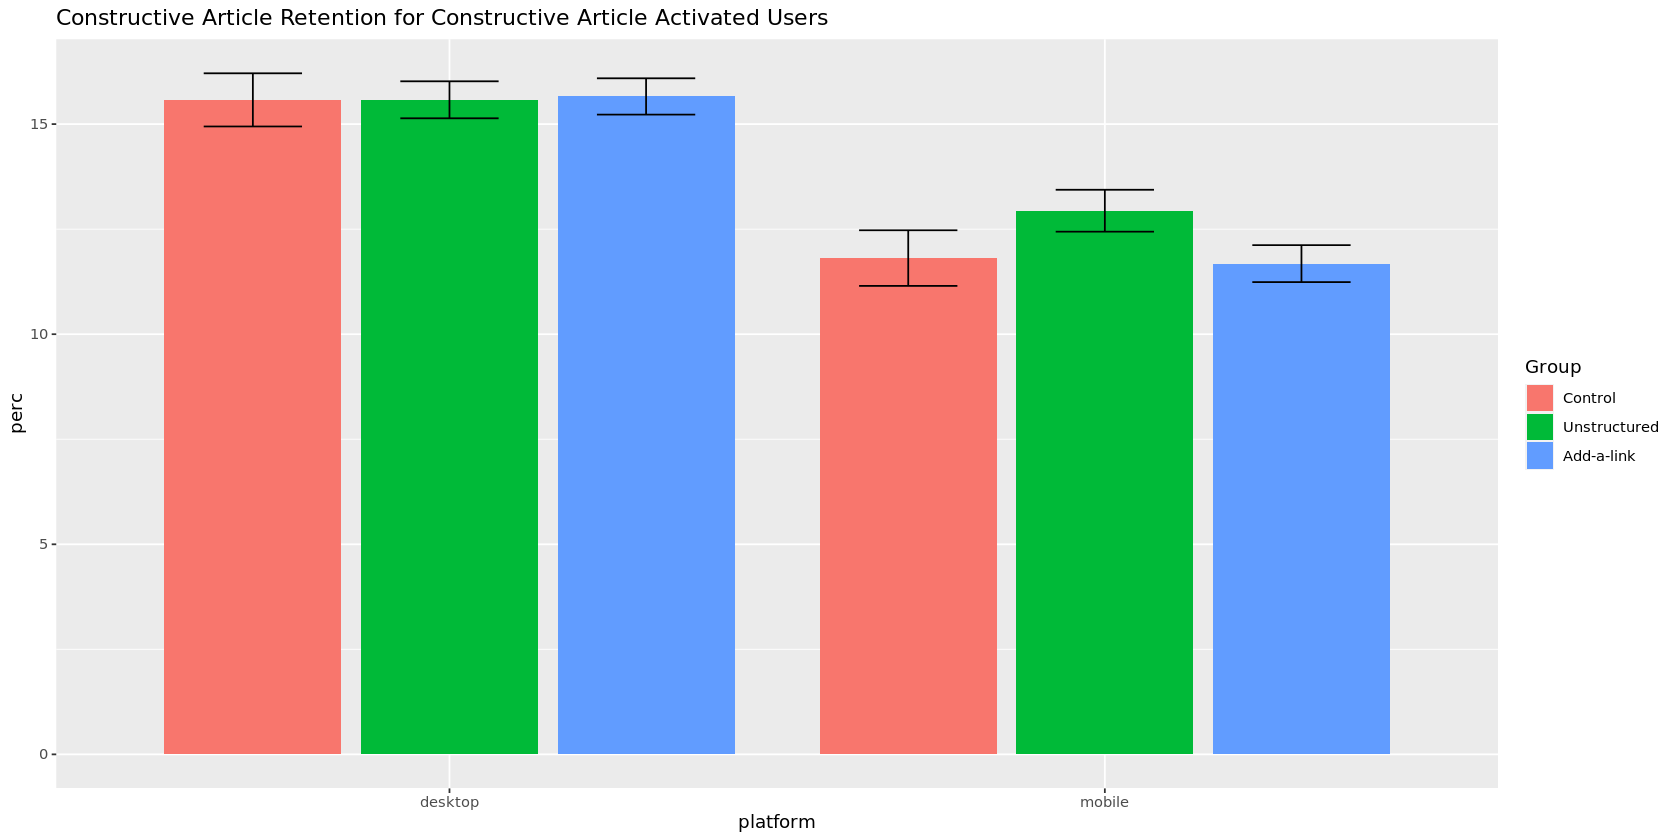

In [33]:
user_edit_data %>%
    filter(is_const_activated_article == TRUE) %>%
    group_by(platform, Group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group) %>%
    mutate(SE = sqrt(prob * (1 - prob) / per_group)) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = platform, y = perc, fill = Group)) +
        labs(title = 'Constructive Article Retention for Constructive Article Activated Users') +
        geom_col(position = 'dodge2') + 
        geom_errorbar(aes(ymin = perc - 100*SE, ymax = perc + 100*SE),
                      position = position_dodge2(width = 0.4, padding = 0.5))

# Fitting Models

## Retention

In [27]:
blas_set_num_threads(16)
retention.overall.1 <-
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [32]:
summary(retention.overall.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   28907    28974   -14446    28893   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.806 -0.271  0.000  0.000  4.102 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0115   0.107   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                    Estimate Std. Error z value             Pr(>|z|)    
(Intercept)         -20.3753     3.3334   -6.11        0.00000000098 ***
platformmobile       -0.3776     0.0328  -11.51 < 0.0000000000000002 ***
GroupUnstructured     0.0258     0.0419    0.62                 0.54    
GroupAdd-a-link       0.0219     0.0416    0.53                 0.60    
is_activatedTRUE     17.2880     3.3321    5.19 

This model reflects the previous graph in that Add a Link increases activation relative to the Control. It looks like in this dataset, the unstructured task might not have significantly higher activation.

Let's check for interaction between `platform` and `Group`:

In [45]:
blas_set_num_threads(16)
retention.overall.2 <-
    glmer(
        formula = is_retained ~ platform * Group + is_activated + log_num_edits_24hrs + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [46]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.overall.2, c("theta", "fixef"))
blas_set_num_threads(16)
retention.overall.2 = update(retention.overall.2, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [37]:
summary(retention.overall.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform * Group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: user_data_train
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   28909    28995   -14445    28891   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.859 -0.275  0.000  0.000  4.183 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0115   0.107   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                   Estimate Std. Error z value
(Intercept)                      -20.351442   2.428639   -8.38
platformmobile                    -0.446347   0.069642   -6.41
GroupUnstructured                 -0.025630   0.055272   -0.46
GroupAdd-a-link                   -0.000904   0.054886   -0.02
is_activatedTRUE                  17.294018 

We don't find conclusive evidence of interaction. The BIC is much worse and none of the predictors for `Group` are significant. Moving on to testing per-wiki effects.

In [38]:
blas_set_num_threads(16)
retention.overall.3 <-
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [39]:
summary(retention.overall.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   28904    28990   -14443    28886   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.764 -0.275  0.000  0.000  4.272 

Random effects:
 Groups  Name           Variance Std.Dev. Corr
 wiki_db (Intercept)    0.00659  0.0812       
         platformmobile 0.01327  0.1152   0.50
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                    Estimate Std. Error z value             Pr(>|z|)    
(Intercept)         -21.3879     1.5563  -13.74 < 0.0000000000000002 ***
platformmobile       -0.3579     0.0529   -6.77       0.000000000013 ***
GroupUnstructured     0.0258     0.0419    0.62                 0.54    
GroupAdd-a-link       0.0222     0.0416    0.53

Unlike activation, there does not appear to be a meaningful per-wiki level of variation when it comes to retention. The model isn't singular, which means there is data, but the BIC is significantly worse compared to Model 1.

In [40]:
blas_set_num_threads(16)
retention.overall.4 <-
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is singular, so we discard it. No indication of a meaningful variation between wikis when it comes to the effect of `Group`. Let's see if there's a variation in the effect of first day activity (which we've seen before in other analyses).

In [41]:
blas_set_num_threads(16)
retention.overall.5 <-
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 + log_num_edits_24hrs | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00522878 (tol = 0.002, component 1)”


In [44]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.overall.5, c("theta", "fixef"))
blas_set_num_threads(16)
retention.overall.5 = update(retention.overall.5, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [47]:
summary(retention.overall.5)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 + log_num_edits_24hrs | wiki_db)
   Data: user_data_train
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   28899    28985   -14441    28881   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.302 -0.278  0.000  0.000  4.180 

Random effects:
 Groups  Name                Variance Std.Dev. Corr 
 wiki_db (Intercept)         0.0544   0.233         
         log_num_edits_24hrs 0.0109   0.104    -0.96
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                    Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -20.3237     1.0502  -19.35 <0.0000000000000002 ***
platformmobile       -0.3740     0.0329  -11.36 <0.0000000000000002 ***
GroupUnstructured     0.0266     0.0419 

This model converges and isn't singular, which suggests that there is some variation. However, the BIC is much worse so the added complexity is not warranted.

### Overall Retention Not Conditioned on Activation

This takes activation and level of activity during the first day out of the question, to see if we increase overall retention.

In [49]:
blas_set_num_threads(16)
retention.overall.10 <-
    glmer(
        formula = is_retained ~ platform + Group + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [50]:
summary(retention.overall.10)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   42500    42547   -21245    42490   104140 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.320 -0.253 -0.238 -0.200  5.446 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0569   0.239   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value            Pr(>|z|)    
(Intercept)        -2.6700     0.0838  -31.84 <0.0000000000000002 ***
platformmobile     -0.3993     0.0297  -13.46 <0.0000000000000002 ***
GroupUnstructured   0.0151     0.0381    0.40               0.692    
GroupAdd-a-link     0.0694     0.0378    1.84               0.067 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
        

The Add a Link group is marginally significant. Given that we didn't find a significant increase in retention when controlling for activation, this suggests that we are indeed increasing retention through increasing activation. This effect might be stronger for constructive article retention.

In [51]:
blas_set_num_threads(16)
retention.overall.11 <-
    glmer(
        formula = is_retained ~ platform * Group + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [52]:
summary(retention.overall.11)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform * Group + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   42501    42568   -21244    42487   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.321 -0.253 -0.239 -0.200  5.565 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0569   0.238   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value
(Intercept)                       -2.6392     0.0865  -30.50
platformmobile                    -0.4739     0.0635   -7.46
GroupUnstructured                 -0.0324     0.0496   -0.65
GroupAdd-a-link                    0.0394     0.0492    0.80
platformmobile:GroupUnstructured   0.1146     0.0774    1.48
platformmobile:GroupAdd-a-link     0.0730     0.0767    0.95
                             

No indication of interaction. I'll leave it here and check retention between the two task types, then move to article retention, rather than dig into per-wiki variation.

In [55]:
blas_set_num_threads(16)
retention.overall.growth.1 <-
    user_data_train %>%
    filter(Group != 'Control') %>%
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00291015 (tol = 0.002, component 1)”


In [56]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.overall.growth.1, c("theta", "fixef"))
blas_set_num_threads(16)
retention.overall.growth.1 = update(retention.overall.growth.1, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [57]:
summary(retention.overall.growth.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: .
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   22933    22989   -11460    22921    82270 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.526 -0.272  0.000  0.000  4.081 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0101   0.101   
Number of obs: 82276, groups:  wiki_db, 10

Fixed effects:
                     Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -27.80230    1.38216  -20.12 <0.0000000000000002 ***
platformmobile       -0.36490    0.03674   -9.93 <0.0000000000000002 ***
GroupAdd-a-link      -0.00492    0.03439   -0.14                0.89    
is_activatedTRUE     24.69649    1.38216   17.87 <0.0000000000000002 ***
log_num_e

No indication that retention is different between the two Growth features groups.

## Article Retention

In [53]:
blas_set_num_threads(16)
retention.article.1 <-
    glmer(
        formula = is_retained_article ~ platform + Group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [54]:
summary(retention.article.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + Group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   21838    21905   -10912    21824   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.76  -0.24   0.00   0.00   4.17 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0128   0.113   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                            Estimate Std. Error z value             Pr(>|z|)
(Intercept)                 -21.3633     2.7977   -7.64    0.000000000000022
platformmobile               -0.3519     0.0382   -9.20 < 0.0000000000000002
GroupUnstructured            -0.0150     0.0487   -0.31                 0.76
GroupAdd-a-link              -0.0196     0.0482   -0.41                 0.68
is_a

No difference between the groups when it comes to overall article retention.

In [58]:
blas_set_num_threads(16)
retention.article.2 <-
    glmer(
        formula = is_retained_article ~ platform * Group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [60]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.article.2, c("theta", "fixef"))
blas_set_num_threads(16)
retention.article.2 = update(retention.article.2, start = start_vals,
                             control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [61]:
summary(retention.article.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform * Group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: user_data_train
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   21841    21927   -10911    21823   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-3.800 -0.238  0.000  0.000  4.200 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0128   0.113   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value
(Intercept)                      -21.3412     1.1945  -17.87
platformmobile                    -0.4073     0.0816   -4.99
GroupUnstructured                 -0.0615     0.0634   -0.97
GroupAdd-a-link                   -0.0311     0.0628   -0.49
is_activated_articleTRUE      

No indication of an interaction effect here. The BIC is worse and none of the variables are significant.

In [63]:
blas_set_num_threads(16)
retention.article.3 <-
    glmer(
        formula = is_retained_article ~ platform + Group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is also singular, so we discard it.

In [103]:
blas_set_num_threads(16)
retention.article.4 <-
    glmer(
        formula = is_retained_article ~ platform + Group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 + log_num_article_edits_24hrs | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



This model is also singular, so we discard it too.

### Constructive Retention Overall

In [80]:
blas_set_num_threads(16)
retention.constr.overall.1 <-
    glmer(
        formula = is_const_retained ~ platform + Group +
                    is_const_activated + log_num_const_edits_24hrs +
                    (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00228826 (tol = 0.002, component 1)”


In [81]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.overall.1, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.overall.1 = update(retention.constr.overall.1, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00306622 (tol = 0.002, component 1)”


In [82]:
blas_set_num_threads(16)
retention.constr.overall.2 <-
    glmer(
        formula = is_const_retained ~ platform + Group +
                    log_num_const_edits_24hrs + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [83]:
summary(retention.constr.overall.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + Group + log_num_const_edits_24hrs +  
    (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   26854    26912   -13421    26842   104139 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.615  -0.178  -0.109  -0.093   6.012 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0269   0.164   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                          Estimate Std. Error z value            Pr(>|z|)    
(Intercept)                -4.3799     0.0725  -60.43 <0.0000000000000002 ***
platformmobile             -0.3817     0.0371  -10.29 <0.0000000000000002 ***
GroupUnstructured           0.0637     0.0469    1.36                0.17    
GroupAdd-a-link             0.0213     0.0467    0.46                0.65    
log_num_const_ed

In [84]:
blas_set_num_threads(16)
retention.constr.overall.3 <-
    glmer(
        formula = is_const_retained ~ platform * Group +
                    log_num_const_edits_24hrs + (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [85]:
summary(retention.constr.overall.3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform * Group + log_num_const_edits_24hrs +  
    (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   26857    26933   -13420    26841   104137 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.708  -0.177  -0.109  -0.092   6.075 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0269   0.164   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                 Estimate Std. Error z value
(Intercept)                      -4.36586    0.07738  -56.42
platformmobile                   -0.41684    0.07850   -5.31
GroupUnstructured                 0.02869    0.06033    0.48
GroupAdd-a-link                   0.02078    0.06002    0.35
log_num_const_edits_24hrs         1.93606    0.02094   92.47
platformmobile:GroupUnstructured  0.0874

No indication of interaction here either. BIC is worse and the estimates are not different from 0.

In [86]:
blas_set_num_threads(16)
retention.constr.overall.4 <-
    glmer(
        formula = is_const_retained ~ platform + Group +
                    log_num_const_edits_24hrs + (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [87]:
summary(retention.constr.overall.4)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + Group + log_num_const_edits_24hrs +  
    (1 + platform | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   26855    26932   -13420    26839   104137 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.283  -0.172  -0.109  -0.092   6.063 

Random effects:
 Groups  Name           Variance Std.Dev. Corr
 wiki_db (Intercept)    0.0213   0.146        
         platformmobile 0.0148   0.122    0.44
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                          Estimate Std. Error z value             Pr(>|z|)    
(Intercept)                -4.3918     0.0700  -62.72 < 0.0000000000000002 ***
platformmobile             -0.3492     0.0592   -5.90         0.0000000037 ***
GroupUnstructured           0.0644     0.0469    1.37                 0.17    
GroupAdd-a-link 

The model is not singular, suggesting there is variation around the popuplation level mean for `platform`. The BIC is worse, indicating that there isn't enough variation to warrant the added complexity. Hence we discard this model too.

In [88]:
blas_set_num_threads(16)
retention.constr.overall.5 <-
    glmer(
        formula = is_const_retained ~ platform + Group +
                    log_num_const_edits_24hrs + (1 + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



That model is, unsurprisingly, singular, so we discard it.

In [89]:
blas_set_num_threads(16)
retention.constr.overall.6 <-
    glmer(
        formula = is_const_retained ~ platform + Group +
                    log_num_const_edits_24hrs + (1 + log_num_const_edits_24hrs | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [90]:
summary(retention.constr.overall.6)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + Group + log_num_const_edits_24hrs +  
    (1 + log_num_const_edits_24hrs | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   26825    26901   -13404    26809   104137 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-12.723  -0.174  -0.106  -0.088   5.973 

Random effects:
 Groups  Name                      Variance Std.Dev. Corr 
 wiki_db (Intercept)               0.0671   0.259         
         log_num_const_edits_24hrs 0.0227   0.151    -0.80
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                          Estimate Std. Error z value            Pr(>|z|)    
(Intercept)                -4.3525     0.0992  -43.88 <0.0000000000000002 ***
platformmobile             -0.3830     0.0371  -10.34 <0.0000000000000002 ***
GroupUnstructured           0.0672     0.0470

This model suggests there *is* variation in the effect of first day activity on overall constructive retention, and based on the BIC this is a meaningful improvement of the model. We therefore keep Model 6 moving forward.

### Constructive Article Retention

In [123]:
blas_set_num_threads(16)
retention.constr.article.1 <-
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [124]:
summary(retention.constr.article.1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + Group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: user_data_train

     AIC      BIC   logLik deviance df.resid 
   17349    17416    -8668    17335   104138 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.54   0.00   0.00   0.00   3.99 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0123   0.111   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                       -22.3706     3.3051   -6.77
platformmobile                     -0.3262     0.0431   -7.57
GroupUnstructured                   0.0236     0.0548    0.43
GroupAdd-a-link                    -0.0333     0.0542   -0.61
is_const_activated_articleTRUE     19.2702     3.3060    5.8

In [125]:
blas_set_num_threads(16)
retention.constr.article.2 <-
    glmer(
        formula = is_const_retained_article ~ platform * Group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [126]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.2, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.2 = update(retention.constr.article.2, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [127]:
summary(retention.constr.article.2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform * Group + is_const_activated_article +  
    log_num_const_article_edits_24hrs + (1 | wiki_db)
   Data: user_data_train
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   17350    17436    -8666    17332   104136 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
 -3.55   0.00   0.00   0.00   4.08 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0122   0.111   
Number of obs: 104145, groups:  wiki_db, 10

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                       -22.3681     2.2905   -9.77
platformmobile                     -0.3427     0.0941   -3.64
GroupUnstructured                  -0.0157     0.0687   -0.23
GroupAdd-a-link                    -0.0103     0.0680   -0.15
is_con

No indications of interactions here.

In [128]:
blas_set_num_threads(16)
retention.constr.article.3 <-
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + platform | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



In [130]:
blas_set_num_threads(16)
retention.constr.article.4 <-
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + Group | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0075024 (tol = 0.002, component 1)”


In [131]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.4, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.4 = update(retention.constr.article.4, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



In [132]:
blas_set_num_threads(16)
retention.constr.article.5 <-
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 + log_num_const_article_edits_24hrs | wiki_db),
        data = user_data_train,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

boundary (singular) fit: see ?isSingular



All of these are singular, so we discard them and stick with Model 1.

## Models on the Full Dataset

### Overall Retention

In [74]:
blas_set_num_threads(16)
retention.overall.full <-
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [75]:
summary(retention.overall.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
   36135    36204   -18061    36121   130172 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-5.019 -0.272  0.000  0.000  4.161 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0149   0.122   
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                     Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -20.37287    1.01232  -20.12 <0.0000000000000002 ***
platformmobile       -0.39002    0.02944  -13.25 <0.0000000000000002 ***
GroupUnstructured     0.03445    0.03742    0.92                0.36    
GroupAdd-a-link       0.00991    0.03725    0.27                0.79    
is_activatedTRUE     17.29762    1.01187   17.09 

In [76]:
blas_set_num_threads(16)
retention.overall.full.growth <-
    glmer(
        formula = is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +
                    (1 | wiki_db),
        data = user_edit_data[user_edit_data$Group != 'Control',],
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [77]:
summary(retention.overall.full.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained ~ platform + Group + is_activated + log_num_edits_24hrs +  
    (1 | wiki_db)
   Data: user_edit_data[user_edit_data$Group != "Control", ]

     AIC      BIC   logLik deviance df.resid 
   28680    28737   -14334    28668   102837 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-5.196 -0.271  0.000  0.000  4.147 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0128   0.113   
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                    Estimate Std. Error z value            Pr(>|z|)    
(Intercept)         -20.3450     0.7881  -25.82 <0.0000000000000002 ***
platformmobile       -0.3772     0.0329  -11.45 <0.0000000000000002 ***
GroupAdd-a-link      -0.0254     0.0307   -0.83                0.41    
is_activatedTRUE     17.2707     0.7876   21.93 <0.0000000000000002 ***
log_num_edits_24h

In [64]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.agg <- user_edit_data %>%
    group_by(Group, is_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.agg

Group,is_retained,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,25953,94.94,94.9
Control,TRUE,1383,5.06,5.1
Unstructured,FALSE,48801,94.80,94.8
Unstructured,TRUE,2678,5.20,5.2
Add-a-link,FALSE,48586,94.59,94.6
Add-a-link,TRUE,2778,5.41,5.4


In [65]:
## Calculate increase in percent
round(retention.overall.agg[4, "perc"] - retention.overall.agg[2, "perc"], 1)

perc
<dbl>
0.1


In [66]:
## Calculate increase in percent
round(100 * (retention.overall.agg[4, "perc"] - retention.overall.agg[2, "perc"]) /
        retention.overall.agg[2,"perc"], 1)

perc
<dbl>
2.8


In [67]:
## Calculate increase in percent
round(retention.overall.agg[6, "perc"] - retention.overall.agg[2, "perc"], 1)

perc
<dbl>
0.3


In [68]:
## Calculate increase in percent
round(100 * (retention.overall.agg[6, "perc"] - retention.overall.agg[2, "perc"]) /
        retention.overall.agg[2,"perc"], 1)

perc
<dbl>
6.9


Same aggregation but based on users who activate:

In [69]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.activated.agg <- user_edit_data %>%
    filter(is_activated == TRUE) %>%
    group_by(Group, is_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.activated.agg

Group,is_retained,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,8911,86.6,86.6
Control,TRUE,1383,13.4,13.4
Unstructured,FALSE,16741,86.2,86.2
Unstructured,TRUE,2678,13.8,13.8
Add-a-link,FALSE,17259,86.1,86.1
Add-a-link,TRUE,2778,13.9,13.9


In [70]:
## Calculate increase in percent
round(retention.overall.activated.agg[4, "perc"] - retention.overall.activated.agg[2, "perc"], 1)

perc
<dbl>
0.4


In [71]:
## Calculate increase in percent
round(100 * (retention.overall.activated.agg[4, "perc"] - retention.overall.activated.agg[2, "perc"]) /
        retention.overall.activated.agg[2,"perc"], 1)

perc
<dbl>
2.6


In [72]:
## Calculate increase in percent
round(retention.overall.activated.agg[6, "perc"] - retention.overall.activated.agg[2, "perc"], 1)

perc
<dbl>
0.4


In [73]:
## Calculate increase in percent
round(100 * (retention.overall.activated.agg[6, "perc"] - retention.overall.activated.agg[2, "perc"]) /
        retention.overall.activated.agg[2,"perc"], 1)

perc
<dbl>
3.2


In [104]:
blas_set_num_threads(16)
retention.article.full <-
    glmer(
        formula = is_retained_article ~ platform + Group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [105]:
summary(retention.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + Group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
   27165    27234   -13576    27151   130172 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-5.036 -0.234  0.000  0.000  4.281 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0138   0.117   
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                            Estimate Std. Error z value            Pr(>|z|)    
(Intercept)                 -21.3698     1.5149  -14.11 <0.0000000000000002 ***
platformmobile               -0.3594     0.0343  -10.46 <0.0000000000000002 ***
GroupUnstructured             0.0246     0.0437    0.56                0.57    
GroupAdd-a-link              -0.0225     0.0435   -0.52               

In [106]:
blas_set_num_threads(16)
retention.article.full.growth <-
    user_edit_data %>%
    filter(Group != 'Control') %>%
    glmer(
        formula = is_retained_article ~ platform + Group +
                    is_activated_article + log_num_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00226019 (tol = 0.002, component 1)”


In [107]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.article.full.growth, c("theta", "fixef"))
blas_set_num_threads(16)
retention.article.full.growth = update(retention.article.full.growth, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

In [108]:
summary(retention.article.full.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + Group + is_activated_article +  
    log_num_article_edits_24hrs + (1 | wiki_db)
   Data: .
Control: glmerControl(optCtrl = list(maxfun = 20000))

     AIC      BIC   logLik deviance df.resid 
   21799    21856   -10894    21787   102837 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-5.232 -0.235  0.000  0.000  4.257 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0114   0.107   
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                            Estimate Std. Error z value            Pr(>|z|)    
(Intercept)                 -28.2225     2.2240  -12.69 <0.0000000000000002 ***
platformmobile               -0.3498     0.0383   -9.14 <0.0000000000000002 ***
GroupAdd-a-link              -0.0480     0.0353   -1.36                0.17    
is_activated_articleTRUE     

In [109]:
blas_set_num_threads(16)
retention.article.full.noactivation <-
    glmer(
        formula = is_retained_article ~ platform + Group + (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [110]:
summary(retention.article.full.noactivation)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + Group + (1 | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
   42627    42676   -21308    42617   130174 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.294 -0.221 -0.192 -0.159  6.859 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0804   0.284   
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value            Pr(>|z|)    
(Intercept)        -2.9951     0.0969  -30.89 <0.0000000000000002 ***
platformmobile     -0.4088     0.0305  -13.40 <0.0000000000000002 ***
GroupUnstructured   0.0603     0.0396    1.53              0.1272    
GroupAdd-a-link     0.1150     0.0393    2.93              0.0034 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
 

In [111]:
blas_set_num_threads(16)
retention.article.full.noactivation.growth <-
    user_edit_data %>%
    filter(Group != 'Control') %>%
    glmer(
        formula = is_retained_article ~ platform + Group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [112]:
summary(retention.article.full.noactivation.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_retained_article ~ platform + Group + (1 | wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
   34191    34229   -17092    34183   102839 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.297 -0.222 -0.196 -0.160  6.566 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0752   0.274   
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      -2.9434     0.0923  -31.89 <0.0000000000000002 ***
platformmobile   -0.4073     0.0340  -11.98 <0.0000000000000002 ***
GroupAdd-a-link   0.0547     0.0318    1.72               0.086 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) pltfrm
platformmbl -0.145       
GrpAdd--lnk -0.175 -0.005

In [15]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.agg <- user_edit_data %>%
    group_by(Group, is_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.agg

Group,is_retained_article,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,26341,96.36,96.4
Control,TRUE,995,3.64,3.6
Unstructured,FALSE,49466,96.09,96.1
Unstructured,TRUE,2013,3.91,3.9
Add-a-link,FALSE,49251,95.89,95.9
Add-a-link,TRUE,2113,4.11,4.1


In [114]:
## Calculate increase in percent
round(retention.article.agg[4, "perc"] - retention.article.agg[2, "perc"], 1)

perc
<dbl>
0.3


In [115]:
## Calculate increase in percent
round(100 * (retention.article.agg[4, "perc"] - retention.article.agg[2, "perc"]) /
        retention.article.agg[2,"perc"], 1)

perc
<dbl>
7.4


In [116]:
## Calculate increase in percent
round(retention.article.agg[6, "perc"] - retention.article.agg[2, "perc"], 1)

perc
<dbl>
0.5


In [117]:
## Calculate increase in percent
round(100 * (retention.article.agg[6, "perc"] - retention.article.agg[2, "perc"]) /
        retention.article.agg[2,"perc"], 1)

perc
<dbl>
13


Same aggregation but based on users who activate:

In [118]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.activated.agg <- user_edit_data %>%
    filter(is_activated_article == TRUE) %>%
    group_by(Group, is_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.activated.agg

Group,is_retained_article,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,6437,86.6,86.6
Control,TRUE,995,13.4,13.4
Unstructured,FALSE,12733,86.3,86.3
Unstructured,TRUE,2013,13.7,13.7
Add-a-link,FALSE,13479,86.4,86.4
Add-a-link,TRUE,2113,13.6,13.6


In [119]:
## Calculate increase in percent
round(retention.article.activated.agg[4, "perc"] - retention.article.activated.agg[2, "perc"], 1)

perc
<dbl>
0.3


In [120]:
## Calculate increase in percent
round(100 * (retention.article.activated.agg[4, "perc"] - retention.article.activated.agg[2, "perc"]) /
        retention.article.activated.agg[2,"perc"], 1)

perc
<dbl>
2


In [121]:
## Calculate increase in percent
round(retention.article.activated.agg[6, "perc"] - retention.article.activated.agg[2, "perc"], 1)

perc
<dbl>
0.2


In [122]:
## Calculate increase in percent
round(100 * (retention.article.activated.agg[6, "perc"] - retention.article.activated.agg[2, "perc"]) /
        retention.article.activated.agg[2,"perc"], 1)

perc
<dbl>
1.2


### Overall Constructive Retention

In [91]:
blas_set_num_threads(16)
retention.constr.overall.full <-
    glmer(
        formula = is_const_retained ~ platform + Group +
                    log_num_const_edits_24hrs + (1 + log_num_const_edits_24hrs | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [92]:
summary(retention.constr.overall.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained ~ platform + Group + log_num_const_edits_24hrs +  
    (1 + log_num_const_edits_24hrs | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
   33580    33658   -16782    33564   130171 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-26.982  -0.175  -0.106  -0.087   6.163 

Random effects:
 Groups  Name                      Variance Std.Dev. Corr 
 wiki_db (Intercept)               0.0722   0.269         
         log_num_const_edits_24hrs 0.0242   0.156    -0.75
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                          Estimate Std. Error z value            Pr(>|z|)    
(Intercept)                -4.3446     0.0988  -43.96 <0.0000000000000002 ***
platformmobile             -0.3846     0.0332  -11.59 <0.0000000000000002 ***
GroupUnstructured           0.0791     0.0419 

In [93]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.constr.agg <- user_edit_data %>%
    group_by(Group, is_const_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.constr.agg

Group,is_const_retained,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,26164,95.71,95.7
Control,TRUE,1172,4.29,4.3
Unstructured,FALSE,49190,95.55,95.6
Unstructured,TRUE,2289,4.45,4.4
Add-a-link,FALSE,48977,95.35,95.4
Add-a-link,TRUE,2387,4.65,4.6


In [94]:
## Calculate increase in percent
round(retention.overall.constr.agg[4, "perc"] - retention.overall.constr.agg[2, "perc"], 1)

perc
<dbl>
0.2


In [95]:
## Calculate increase in percent
round(100 * (retention.overall.constr.agg[4, "perc"] - retention.overall.constr.agg[2, "perc"]) /
        retention.overall.constr.agg[2,"perc"], 1)

perc
<dbl>
3.7


In [96]:
## Calculate increase in percent
round(retention.overall.constr.agg[6, "perc"] - retention.overall.constr.agg[2, "perc"], 1)

perc
<dbl>
0.4


In [97]:
## Calculate increase in percent
round(100 * (retention.overall.constr.agg[6, "perc"] - retention.overall.constr.agg[2, "perc"]) /
        retention.overall.constr.agg[2,"perc"], 1)

perc
<dbl>
8.4


Same aggregation but based on users who constructively activate:

In [98]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.overall.const_activated.agg <- user_edit_data %>%
    filter(is_const_activated == TRUE) %>%
    group_by(Group, is_const_retained) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.overall.const_activated.agg

Group,is_const_retained,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,7406,86.3,86.3
Control,TRUE,1172,13.7,13.7
Unstructured,FALSE,13873,85.8,85.8
Unstructured,TRUE,2289,14.2,14.2
Add-a-link,FALSE,14603,86.0,86.0
Add-a-link,TRUE,2387,14.0,14.0


In [99]:
## Calculate increase in percent
round(retention.overall.const_activated.agg[4, "perc"] - retention.overall.const_activated.agg[2, "perc"], 1)

perc
<dbl>
0.5


In [100]:
## Calculate increase in percent
round(100 * (retention.overall.const_activated.agg[4, "perc"] - retention.overall.const_activated.agg[2, "perc"]) /
        retention.overall.const_activated.agg[2,"perc"], 1)

perc
<dbl>
3.7


In [101]:
## Calculate increase in percent
round(retention.overall.const_activated.agg[6, "perc"] - retention.overall.const_activated.agg[2, "perc"], 1)

perc
<dbl>
0.4


In [102]:
## Calculate increase in percent
round(100 * (retention.overall.const_activated.agg[6, "perc"] - retention.overall.const_activated.agg[2, "perc"]) /
        retention.overall.const_activated.agg[2,"perc"], 1)

perc
<dbl>
2.8


### Constructive Article Retention

In [133]:
blas_set_num_threads(16)
retention.constr.article.full <-
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    is_const_activated_article + log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“unable to evaluate scaled gradient”
Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge: degenerate  Hessian with 1 negative eigenvalues”


In [134]:
## If model didn't converge, restart and give it some more iterations:
start_vals = getME(retention.constr.article.full, c("theta", "fixef"))
blas_set_num_threads(16)
retention.constr.article.full = update(retention.constr.article.full, start = start_vals,
                                    control = glmerControl(optCtrl = list(maxfun = 2e4)))
blas_set_num_threads(1)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.00441432 (tol = 0.002, component 1)”


In [135]:
blas_set_num_threads(16)
retention.constr.article.full <-
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [136]:
summary(retention.constr.article.full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + Group + log_num_const_article_edits_24hrs +  
    (1 | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
   24527    24586   -12258    24515   130173 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-38.23  -0.10  -0.09  -0.08   6.78 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0241   0.155   
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                        -4.6717     0.0723  -64.64
platformmobile                     -0.4149     0.0402  -10.33
GroupUnstructured                   0.1024     0.0506    2.02
GroupAdd-a-link                    -0.0138     0.0505   -0.27
log_num_const_article_edits_24hrs   2.1151     0.0220   96.33
                            

In [139]:
blas_set_num_threads(16)
retention.constr.article.full.growth <-
    user_edit_data %>%
    filter(Group != 'Control') %>%
    glmer(
        formula = is_const_retained_article ~ platform + Group +
                    log_num_const_article_edits_24hrs +
                    (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [140]:
summary(retention.constr.article.full.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: 
is_const_retained_article ~ platform + Group + log_num_const_article_edits_24hrs +  
    (1 | wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
   19752    19800    -9871    19742   102838 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-37.69  -0.10  -0.09  -0.08   6.54 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0105   0.102   
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                                  Estimate Std. Error z value
(Intercept)                        -4.5661     0.0562  -81.30
platformmobile                     -0.4241     0.0445   -9.54
GroupAdd-a-link                    -0.1151     0.0410   -2.80
log_num_const_article_edits_24hrs   2.1066     0.0245   86.14
                                             Pr(>|z|)    
(Intercept)                       <0.00000000

In [141]:
blas_set_num_threads(16)
retention.constr.article.noactivation <-
    glmer(
        formula = is_const_retained_article ~ platform + Group + (1 | wiki_db),
        data = user_edit_data,
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [142]:
summary(retention.constr.article.noactivation)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ platform + Group + (1 | wiki_db)
   Data: user_edit_data

     AIC      BIC   logLik deviance df.resid 
   36176    36225   -18083    36166   130174 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.275 -0.206 -0.173 -0.145  8.273 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0926   0.304   
Number of obs: 130179, groups:  wiki_db, 10

Fixed effects:
                  Estimate Std. Error z value            Pr(>|z|)    
(Intercept)        -3.1508     0.1032  -30.53 <0.0000000000000002 ***
platformmobile     -0.5833     0.0343  -16.98 <0.0000000000000002 ***
GroupUnstructured   0.0799     0.0437    1.83              0.0677 .  
GroupAdd-a-link     0.1393     0.0434    3.21              0.0013 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effe

In [143]:
blas_set_num_threads(16)
retention.constr.article.noactivation.growth <-
    user_edit_data %>%
    filter(Group != 'Control') %>%
    glmer(
        formula = is_const_retained_article ~ platform + Group + (1 | wiki_db),
        family = binomial(link = "logit"))
blas_set_num_threads(1)

In [144]:
summary(retention.constr.article.noactivation.growth)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: is_const_retained_article ~ platform + Group + (1 | wiki_db)
   Data: .

     AIC      BIC   logLik deviance df.resid 
   29140    29178   -14566    29132   102839 

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-0.277 -0.207 -0.173 -0.150  7.945 

Random effects:
 Groups  Name        Variance Std.Dev.
 wiki_db (Intercept) 0.0843   0.29    
Number of obs: 102843, groups:  wiki_db, 10

Fixed effects:
                Estimate Std. Error z value            Pr(>|z|)    
(Intercept)      -3.0768     0.0978  -31.47 <0.0000000000000002 ***
platformmobile   -0.5814     0.0382  -15.22 <0.0000000000000002 ***
GroupAdd-a-link   0.0594     0.0351    1.69               0.091 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) pltfrm
platformmbl -0.138       
GrpAdd--lnk -0.183 -0.005

In [16]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.constr.agg <- user_edit_data %>%
    group_by(Group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.constr.agg

Group,is_const_retained_article,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,26543,97.10,97.1
Control,TRUE,793,2.90,2.9
Unstructured,FALSE,49838,96.81,96.8
Unstructured,TRUE,1641,3.19,3.2
Add-a-link,FALSE,49633,96.63,96.6
Add-a-link,TRUE,1731,3.37,3.4


In [17]:
## Calculate increase in percent
round(retention.article.constr.agg[4, "perc"] - retention.article.constr.agg[2, "perc"], 1)

perc
<dbl>
0.3


In [18]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[4, "perc"] - retention.article.constr.agg[2, "perc"]) /
        retention.article.constr.agg[2,"perc"], 1)

perc
<dbl>
9.9


In [19]:
## Calculate increase in percent
round(retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[2, "perc"], 1)

perc
<dbl>
0.5


In [20]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[2, "perc"]) /
        retention.article.constr.agg[2,"perc"], 1)

perc
<dbl>
16.2


Difference in percentage points and relative difference between the unstructured and structured task groups:

In [21]:
## Calculate increase in percent
round(retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[4, "perc"], 1)

perc
<dbl>
0.2


In [22]:
## Calculate increase in percent
round(100 * (retention.article.constr.agg[6, "perc"] - retention.article.constr.agg[4, "perc"]) /
        retention.article.constr.agg[4,"perc"], 1)

perc
<dbl>
5.7


Same aggregation but based on users who constructively activate:

In [150]:
# Aggregate across the entire dataset the proportion of registrations retained
retention.article.const_activated.agg <- user_edit_data %>%
    filter(is_const_activated_article == TRUE) %>%
    group_by(Group, is_const_retained_article) %>%
    summarize(n = n(), .groups = 'keep') %>%
    group_by(Group) %>%
    mutate(perc = 100 * n / sum(n), rounded_perc = round(100 * n / sum(n), 1))
retention.article.const_activated.agg

Group,is_const_retained_article,n,perc,rounded_perc
<fct>,<lgl>,<int>,<dbl>,<dbl>
Control,FALSE,4873,86.0,86.0
Control,TRUE,793,14.0,14.0
Unstructured,FALSE,9660,85.5,85.5
Unstructured,TRUE,1641,14.5,14.5
Add-a-link,FALSE,10679,86.1,86.1
Add-a-link,TRUE,1731,13.9,13.9


In [151]:
## Calculate increase in percent
round(retention.article.const_activated.agg[4, "perc"] - retention.article.const_activated.agg[2, "perc"], 1)

perc
<dbl>
0.5


In [152]:
## Calculate increase in percent
round(100 * (retention.article.const_activated.agg[4, "perc"] - retention.article.const_activated.agg[2, "perc"]) /
        retention.article.const_activated.agg[2,"perc"], 1)

perc
<dbl>
3.8


In [153]:
## Calculate increase in percent
round(retention.article.const_activated.agg[6, "perc"] - retention.article.const_activated.agg[2, "perc"], 1)

perc
<dbl>
0


In [154]:
## Calculate increase in percent
round(100 * (retention.article.const_activated.agg[6, "perc"] - retention.article.const_activated.agg[2, "perc"]) /
        retention.article.const_activated.agg[2,"perc"], 1)

perc
<dbl>
-0.3


# Graphs

## Article Retention

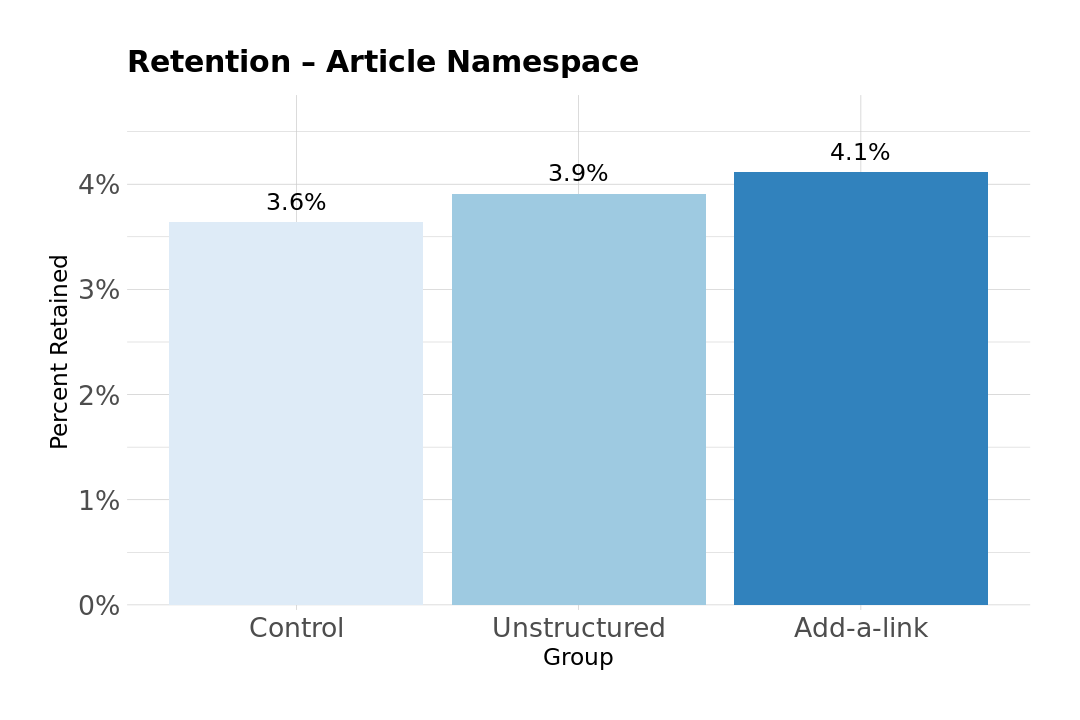

In [32]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group, is_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group,
           group_name = ifelse(Group == 'C', 'Control', 'Treatment')) %>%
    filter(is_retained_article == TRUE) %>%
    ggplot(aes(x = Group, y = prob, fill = Group)) +
        labs(title = 'Retention – Article Namespace', x = 'Group', y = 'Percent Retained') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.048)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.002, size = 5)
ggsave(
    'add-a-link-article-namespace-retention-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")

## Constructive Article Retention

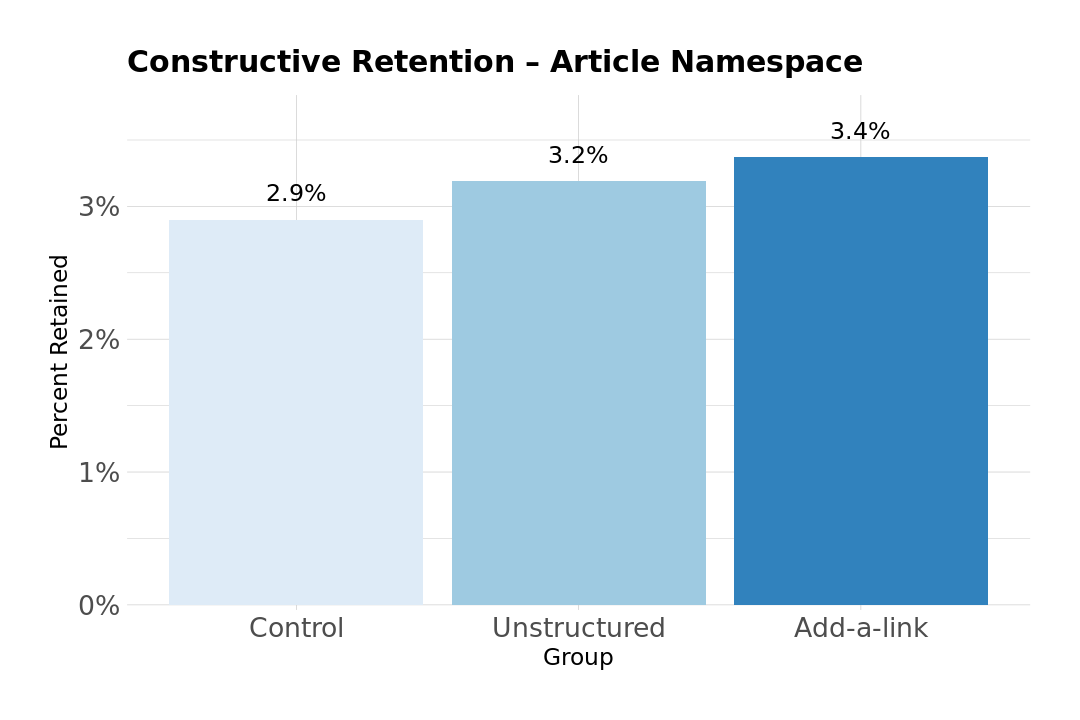

In [33]:
# Give me wider plots, please
options(repr.plot.width = 9, repr.plot.height = 6)
user_edit_data %>%
    group_by(Group, is_const_retained_article) %>%
    tally() %>%
    mutate(per_group = sum(n)) %>%
    ungroup() %>%
    mutate(perc = 100 * n / per_group, prob = n / per_group,
           group_name = ifelse(Group == 'C', 'Control', 'Treatment')) %>%
    filter(is_const_retained_article == TRUE) %>%
    ggplot(aes(x = Group, y = prob, fill = Group)) +
        labs(title = 'Constructive Retention – Article Namespace', x = 'Group', y = 'Percent Retained') +
        hrbrthemes::theme_ipsum("DejaVu Sans", base_size = 16, strip_text_face = "bold", strip_text_size = 18,
                            caption_size = 12, axis_title_size = 14, subtitle_size = 14,
                            axis_title_just = 'cm') +
        guides(fill = 'none') +
        scale_fill_brewer() +
        hrbrthemes::scale_y_percent(limits = c(0, 0.038)) +
        geom_col() +
        geom_text(aes(label = wmfdata::percent2(prob)), nudge_y = 0.002, size = 5)
ggsave(
    'add-a-link-article-namespace-constructive-retention-2021-experiment.png',
    path = 'graphs',
    width = 9, height = 6, units = "in", dpi = "screen")